In [622]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [623]:
### Read in values from text file
file_path = r"Cc_Input.txt"  # Replace with the actual path to your file

values = {}
with open(file_path, "r") as file:
    line = file.readline().strip()
    while line:
        if line.startswith("$$"):
            key = line[2:].strip()
            value = float(file.readline().strip())
            values[key] = value
        line = file.readline().strip()
        

### Store Input Variables

In [624]:
### Cc Inputs
Pre_ConsolStress = values["PRECONSOLIDATION_STRESS"]
Cc = values["Cc"] # Virgin compression slope
Cr_ratio = values["Cr/Cc"] # Ratio of C_r to C_c
e0 = values["e0"] # Initial void ratio
ef = values["ef"] # Final value of void ratio
input_num_points = int(values["Input_Num_Points"]) # Number of spaces avalialable for inputs in PSDDF

### Ck Inputs
Cv = values["Cv (cm^2/s)"] * 1e-4
gamma_w = values["Gamma_w (kN/m^3)"]

In [625]:
num_points = input_num_points + 1 # Add a data point so that when the Cr and Cc arrays are later appened the length is correct

### Calculations

In [626]:
# Calculate the maximum eff_stres possible before e becomes negative
max_stress = 10**((e0-ef)/Cc + np.log10(Pre_ConsolStress) * (-Cr_ratio + 1))
print(max_stress)
# Percentage of the loading that is reloading (swell)
# (Used to calculate the number of points that should be used for the recompression)
Perc_reloading = (Pre_ConsolStress-1)/max_stress
print(Perc_reloading*100)

16.947751781488464
82.60682703231346


In [627]:
# Number of points to generate
# num_points = 100 + 1

### Rework this!!! This will likely cause a bug 
# Number of recompression points
num_Cr_points = int(num_points * Perc_reloading + 1)
if num_Cr_points < 4 and Pre_ConsolStress > 1:
    num_Cr_points = 4
print("Number of Cr points: {:.2f}".format(num_Cr_points))

# Number of virgin compression points
num_Cc_points = num_points-num_Cr_points
print("Number of Cc points: {:.2f}".format(num_Cc_points))

Number of Cr points: 57.00
Number of Cc points: 12.00


In [628]:
### Define arrays of effective stress points

#### Virgin Compression initialization
Cc_eff_stress = np.linspace(Pre_ConsolStress, max_stress, num_Cc_points)

#### Recompression initializations 
Cr_eff_stress = np.linspace(1, Pre_ConsolStress,num_Cr_points)

In [629]:
### Void ratio points for recompression
e_recomp = -1 * Cr_ratio * Cc * np.log10(Cr_eff_stress) + e0

### Void ratio for virgin compression

# Calculate intercept for Virgin compression line
b = e_recomp[-1] + Cc * np.log10(Pre_ConsolStress)

# Calulcate void ratios for virgin compression line
e_virgin = -Cc * np.log10(Cc_eff_stress) + b

### Append the two arrays
eff_stress = np.append(Cr_eff_stress, Cc_eff_stress[1:])
es = np.append(e_recomp, e_virgin[1:])

### Plot

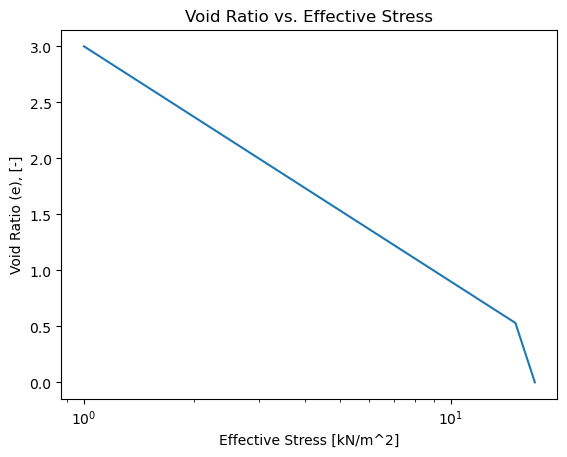

In [630]:
plt.title("Void Ratio vs. Effective Stress")
plt.xlabel("Effective Stress [kN/m^2]")
plt.ylabel("Void Ratio (e), [-]")
plt.semilogx(eff_stress, es)

plt.show()

### Permeability Information

Permeability, $k_{v}$, is defined as 
\begin{equation}
    k_{v} = \gamma_w m_{v} c_{v}
\end{equation}
where, <br>
$\gamma_w$: Specific weight of water <br>
$m_{v}$: Coefficient of compressibility <br>
$c_{v}$: consolidation coefficient <br>

Assuming that $\gamma_w$ and $c_v$ are known then the only unknown is $m_v$. <br>
$m_{v}$ is defined as:
\begin{equation}
    m_{v} = \frac{\Delta \varepsilon_{V}}{\Delta \sigma}
\end{equation}
where $\Delta \varepsilon$ represents a change in volumetric strain and $\Delta \sigma$ represents the corresponding change in stress.

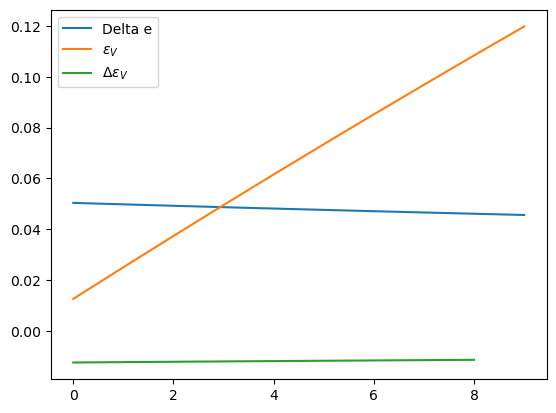

In [631]:
# Calc changes in void ratio
delta_es = es[num_Cr_points:-1] - es[num_Cr_points+1:]
plt.plot(delta_es, label = "Delta e")

# # Calc volumetric strain
epsilon_V = np.cumsum(delta_es)/(1+e0)
plt.plot(epsilon_V, label = "$\epsilon_{V}$")


# # Calc delta volumetric strain
delta_epsilon_V = epsilon_V[:-1] - epsilon_V[1:]

plt.plot(delta_epsilon_V, label = "$\Delta \epsilon_{V}$")
plt.legend()
plt.show()

In [632]:
# Calc delta stress
delta_eff_stress = eff_stress[num_Cr_points] - eff_stress[num_Cr_points+1]

# Calc m_v
m_v = delta_epsilon_V/delta_eff_stress #[-/kN]

# Calc permeability
k = gamma_w * m_v * Cv * 100 #[cm/s]

#least-Squares fit of data
coefficients = np.polyfit(np.log10(k), es[num_Cr_points + 2:], deg = 1)

# Generate the best-fit line
best_fit_line = np.polyval(coefficients, np.log10(k))

# Print Best fit coefficients
print("## LS- Best fit coefficients ##")
print("Slope: {:.4f}\nIntercept: {:.4f}".format(coefficients[0], coefficients[1]))


## LS- Best fit coefficients ##
Slope: 9.9452
Intercept: 1.9835


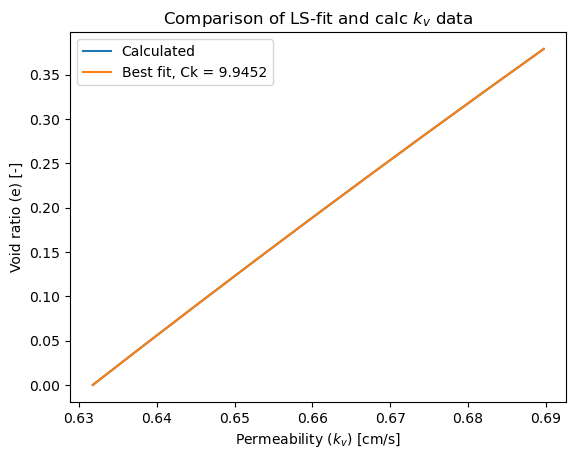

In [633]:
# Plot calculated permeability
plt.plot(k, es[num_Cr_points + 2:], label = "Calculated")

#Plot fitted permeability
plt.plot(k, best_fit_line, label = "Best fit, Ck = {:.4f}".format(coefficients[0]))

#Plot properties
plt.title("Comparison of LS-fit and calc $k_{v}$ data")
plt.xlabel("Permeability ($k_{v}$) [cm/s]")
plt.ylabel("Void ratio (e) [-]")
plt.legend()
plt.show()

In [634]:
### Generate Columns for PSDDF

### Need three columns void ratio | effective stress | permeability
# Before appending the columns together need to add data points to pearmeability data

